<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist-vae-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE and GAN on MNIST data with TensorFlow 2

Sources for this notebook
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://github.com/ageron/handson-ml2
  * https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
* https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/
  * https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch17.html#autoencoders_chapter
* VAE Paper "Auto-Encoding Variational Bayes": https://arxiv.org/abs/1312.6114

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Wed Jan  1 14:15:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
np.random.seed(42)

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

## MNIST data set

In [9]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

In [0]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")

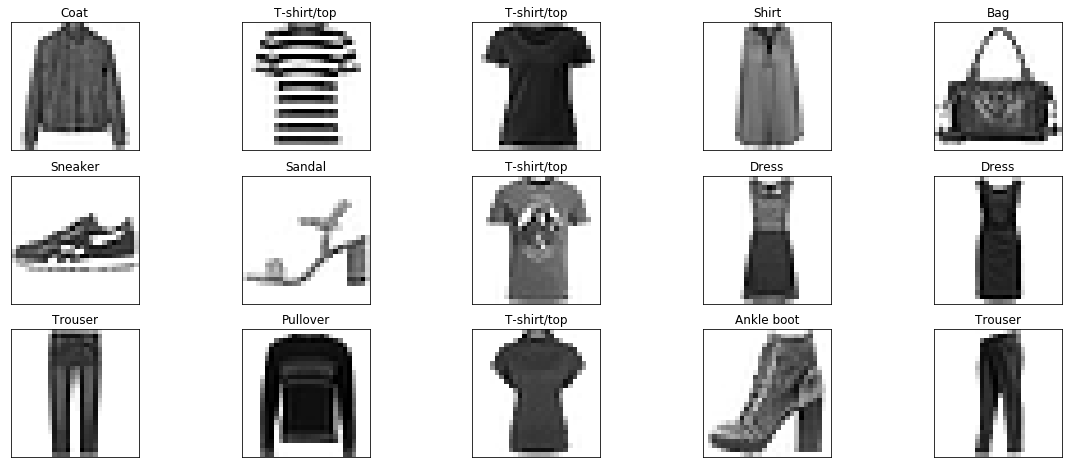

In [12]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)

## CNN through Dense Lantent Space

In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
# KL divergence between the target distribution (i.e., the Gaussian distribution) and the actual distribution of the codings
# kl loss on var/mean is for regularization and optional
# @tf.function
def latent_loss(codings_log_var, codings_mean):
  latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
  return K.mean(latent_loss) / image_size

In [0]:
from tensorflow import keras
import tensorflow.keras.backend as K

# if this looks like a surprising way of sampling: it is like this for a reason
# this makes sure it is derivable using the "reparameterization trick"
# VAE Paper "Auto-Encoding Variational Bayes": https://arxiv.org/abs/1312.6114
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eps = tf.random.normal(tf.shape(log_var))
        return mean + tf.math.exp(log_var / 2) * eps

In [0]:
import tensorflow.keras.backend as K

# codings_size = 10
# to make it plotable directly
codings_size = 2

inputs = keras.layers.Input(shape=[x_res, y_res])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="relu")(z)
z = keras.layers.Dense(100, activation="relu")(z)

# a number of distributions (codings_size)
codings_mean = keras.layers.Dense(codings_size, activation='linear', name='mean')(z)
# turns out training log var makes computation more stable
codings_log_var = keras.layers.Dense(codings_size, activation='linear', name='log_var')(z)

# sampling from those embeddings
codings = Sampling(name='sampling')([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = keras.layers.Dense(150, activation="relu")(x)
x = keras.layers.Dense(image_size, activation="sigmoid")(x)
outputs = keras.layers.Reshape([x_res, y_res])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

variational_ae.add_loss(latent_loss(codings_log_var, codings_mean))

variational_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])
# variational_ae.summary()
# variational_encoder.summary()

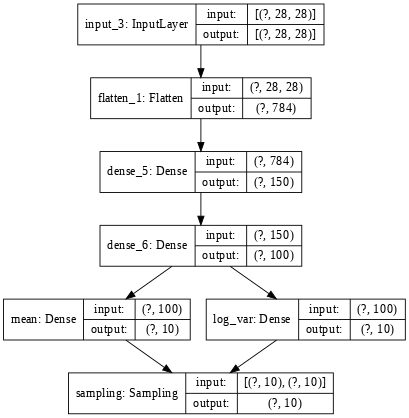

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(variational_encoder, show_shapes=True, dpi=64)

In [0]:
# plot_model(variational_decoder, show_shapes=True, dpi=64)

In [35]:
%%time

BATCH_SIZE = 128
EPOCHS = 25

history = variational_ae.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 26s, sys: 7 s, total: 1min 33s
Wall time: 1min 3s


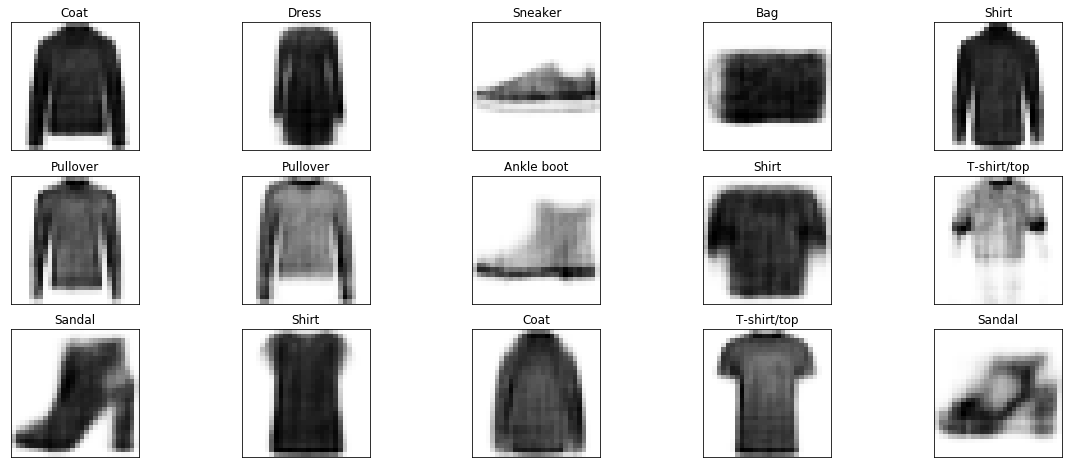

In [36]:
x_test_pred = variational_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

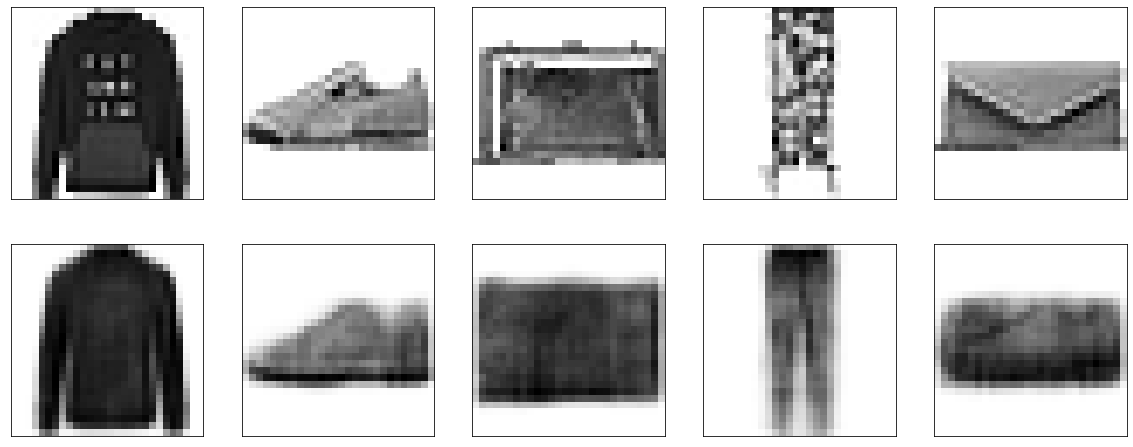

In [37]:
compare_samples(x_test, x_test_pred)

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

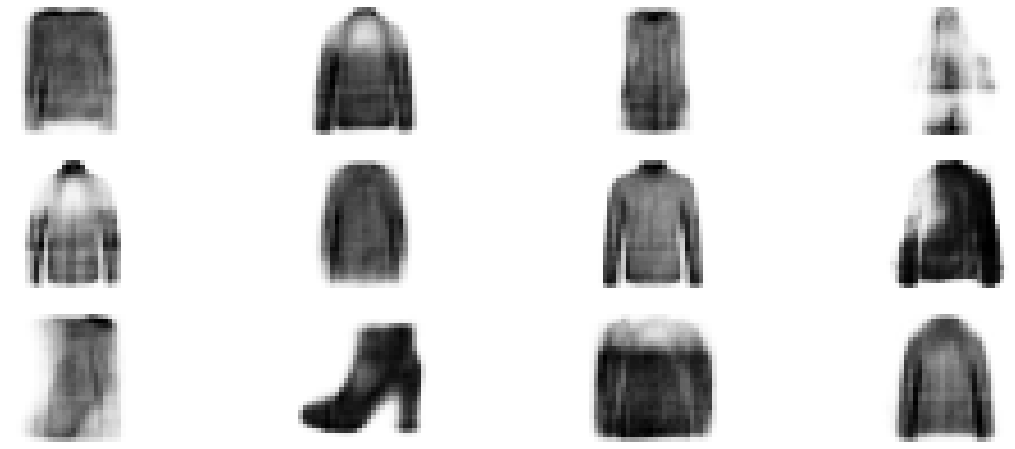

In [39]:
# if you regularize using KL with gaussian distribution, you can simply sample from a gaussian here
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

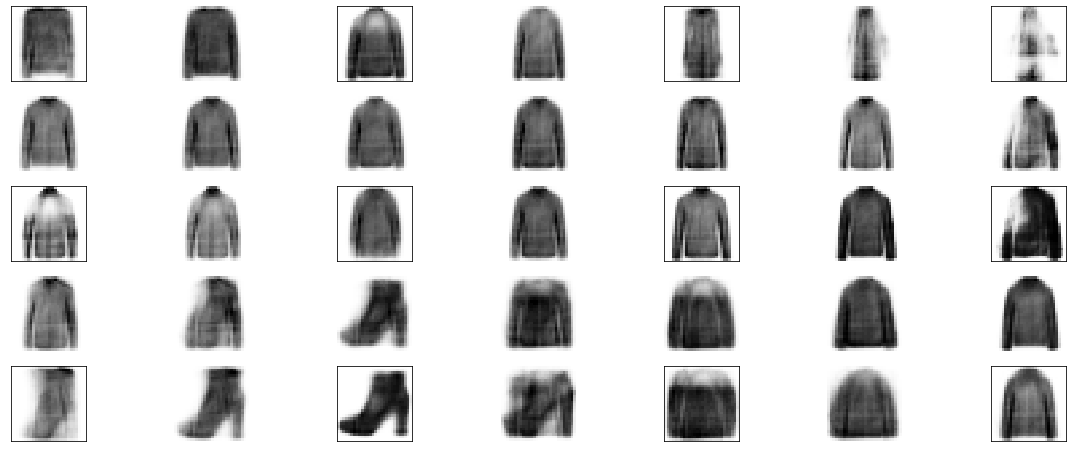

In [40]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

In [41]:
z_mean, _, _ = variational_encoder.predict(x_test)
z_mean.shape

(10000, 10)

In [42]:
z_mean[0]

array([-0.63076645,  0.5297576 ,  0.02889877,  0.00914831, -1.6103692 ,
        0.35464048, -0.356871  ,  2.0174208 , -0.15103479, -1.3621415 ],
      dtype=float32)

In [43]:
tf.reduce_mean(z_mean), tf.reduce_mean(codings_size - tf.cast(tf.math.count_nonzero(z_mean, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.03694767>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [44]:
%%time

import umap

if codings_size == 2:
  embeddings_2d = z_mean
else:
  print('reducing dim using umap')
  reducer = umap.UMAP(random_state=42)
  embeddings_2d = reducer.fit_transform(z_mean)

reducing dim using umap
CPU times: user 30.9 s, sys: 225 ms, total: 31.2 s
Wall time: 30.8 s


In [45]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

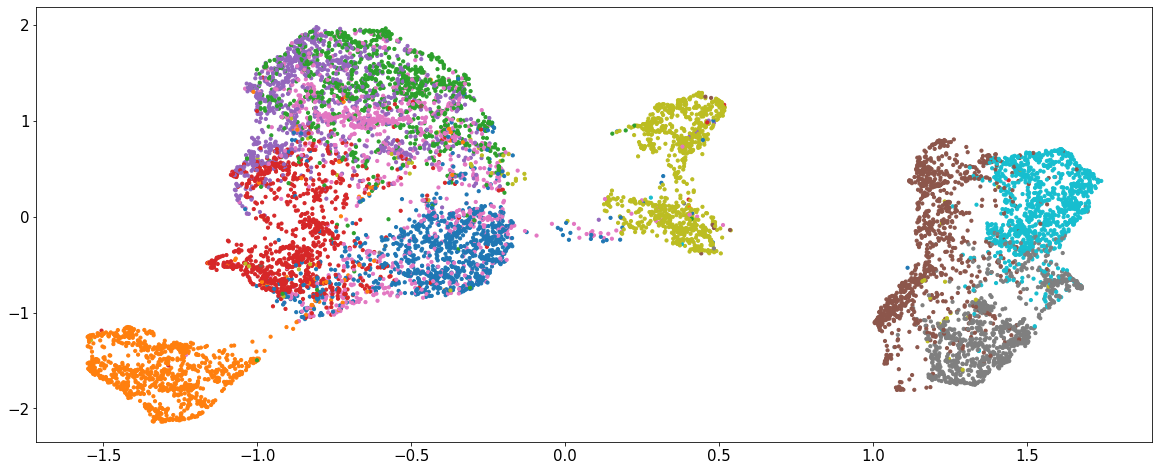

In [46]:
cmap = plt.cm.tab10

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap);

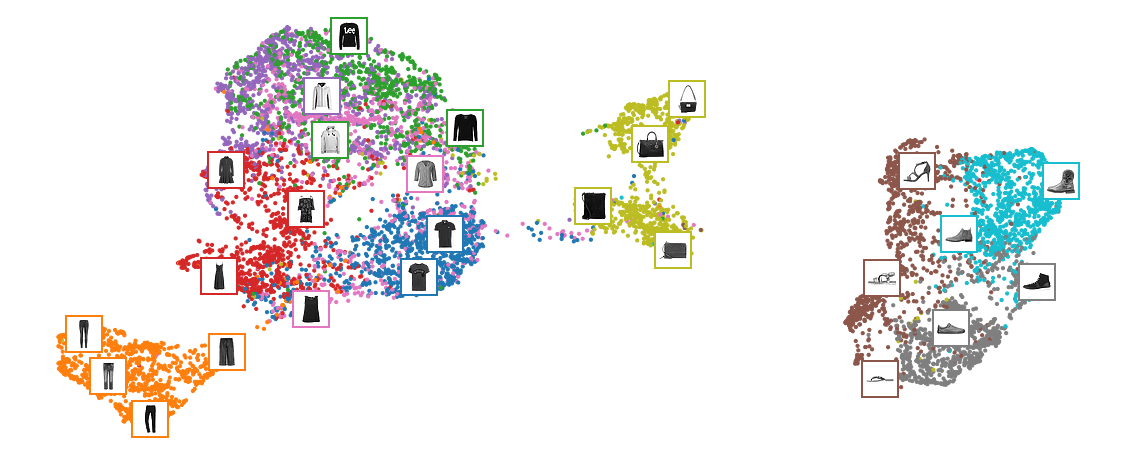

In [47]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");